# Fake vs Real Comment Detection Lab
## Using Linguistic Preprocessing with SpaCy and PyTorch Neural Networks


## Setup: Install Required Libraries

In [ ]:
# Install required packages
!pip install spacy scikit-learn pandas numpy torch --quiet
!python -m spacy download en_core_web_sm --quiet


## Import Libraries


In [1]:
import spacy
from spacy import displacy
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import warnings
warnings.filterwarnings('ignore')


## Load and Explore Dataset

Our dataset contains product reviews with labels:
- **CG** = Computer Generated (Fake)
- **OR** = Original (Real)


In [2]:
df = pd.read_csv('/Users/devrajsinhgohil/Desktop/DL/fake_reviews_dataset.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nLabel distribution:\n{df['label'].value_counts()}")
print("\nFirst few rows:")
df.head()


Dataset shape: (40432, 4)

Label distribution:
label
CG    20216
OR    20216
Name: count, dtype: int64

First few rows:


,category,rating,label,text_
0,Home_and_Kitchen_5,5.0,CG,"Love this! Well made, sturdy, and very comfor..."
1,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrade from the original. I..."
2,Home_and_Kitchen_5,5.0,CG,This pillow saved my back. I love the look and...
3,Home_and_Kitchen_5,1.0,CG,"Missing information on how to use it, but it i..."
4,Home_and_Kitchen_5,5.0,CG,Very nice set. Good quality. We have had the s...


---

# Part 1: Baseline (No Linguistics – Just Text)

First, let's see what happens when we **don't** use sophisticated NLP.

## Step 1: Clean & Vectorize (Bag of Words)


In [3]:
# Filter for only Home_and_Kitchen_5 category
df_filtered = df

# Extract texts and labels
texts = df_filtered['text_'].values
labels = (df_filtered['label'] == 'CG').astype(int).values  # 1 = Fake (CG), 0 = Real (OR)

print(f"Category: Home_and_Kitchen_5")
print(f"Number of texts: {len(texts)}")
print(f"Number of fake reviews: {sum(labels)}")
print(f"Number of real reviews: {len(labels) - sum(labels)}")


Category: Home_and_Kitchen_5
Number of texts: 40432
Number of fake reviews: 20216
Number of real reviews: 20216


In [4]:
# Bag of Words Vectorization
vectorizer_bow = CountVectorizer(lowercase=True, max_features=100)
X_bow = vectorizer_bow.fit_transform(texts)

print(f"\nBag of Words matrix shape: {X_bow.shape}")
print(f"   - {X_bow.shape[0]} documents")
print(f"   - {X_bow.shape[1]} unique words (features)")

# Show example features
feature_names = vectorizer_bow.get_feature_names_out()
print(f"\nExample features: {list(feature_names[:20])}")



Bag of Words matrix shape: (40432, 100)
   - 40432 documents
   - 100 unique words (features)

Example features: ['about', 'all', 'also', 'am', 'an', 'and', 'are', 'as', 'at', 'be', 'because', 'been', 'bit', 'book', 'bought', 'but', 'by', 'can', 'characters', 'do']


### Discussion Point:

**Ask yourself:**
> "Does this understand language — or just count tokens?"

**Observations:**
- Each column = a word
- Order is **ignored**
- Grammar is **ignored**
- *"love" and "loved" are treated as different features*

---


# Part 2: Linguistic Preprocessing with spaCy

Now the fun begins!

## Step 2: Load spaCy Pipeline


In [5]:
# Load spaCy English model
nlp = spacy.load("en_core_web_sm")

print("spaCy model loaded!")
print(f"Pipeline components: {nlp.pipe_names}")


spaCy model loaded!
Pipeline components: ['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']


## Feature 1: Sentence Segmentation

Let's analyze sentence structure in fake vs real reviews.


In [6]:
def analyze_sentences(text):
    doc = nlp(text)
    sentences = [sent.text.strip() for sent in doc.sents]
    return sentences

# Analyze a fake review
fake_example = texts[0]
print("FAKE Review:")
print(f"Text: {fake_example}\n")
fake_sents = analyze_sentences(fake_example)
print(f"Sentences ({len(fake_sents)}):")
for i, sent in enumerate(fake_sents, 1):
    print(f"  {i}. {sent}")

# Analyze a real review
real_example = texts[2]
print("\nREAL Review:")
print(f"Text: {real_example}\n")
real_sents = analyze_sentences(real_example)
print(f"Sentences ({len(real_sents)}):")
for i, sent in enumerate(real_sents, 1):
    print(f"  {i}. {sent}")


FAKE Review:
Text: Love this!  Well made, sturdy, and very comfortable.  I love it!Very pretty

Sentences (3):
  1. Love this!
  2. Well made, sturdy, and very comfortable.
  3. I love it!Very pretty

REAL Review:
Text: This pillow saved my back. I love the look and feel of this pillow.

Sentences (2):
  1. This pillow saved my back.
  2. I love the look and feel of this pillow.


### Insight:
- Fake reviews often use **short, repetitive sentences**
- Real reviews tend to be **more descriptive and varied**

---


## Feature 2: Stop Word Removal


In [7]:
def remove_stopwords(text):
    doc = nlp(text)
    tokens = [token.text for token in doc 
              if not token.is_stop and not token.is_punct]
    return tokens

example_text = "The product is very good and I love it"
print(f"Original: {example_text}")
print(f"Without stopwords: {' '.join(remove_stopwords(example_text))}")

print("\nExplanation:")
print("  - Removes: 'the', 'is', 'and', 'I', 'it'")
print("  - Keeps: content words (nouns, verbs, adjectives)")
print("  - Reduces noise in the data")


Original: The product is very good and I love it
Without stopwords: product good love

Explanation:
  - Removes: 'the', 'is', 'and', 'I', 'it'
  - Keeps: content words (nouns, verbs, adjectives)
  - Reduces noise in the data


## Feature 3: Lemmatization

Convert words to their base form.


In [8]:
def lemmatize_text(text):
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc 
              if not token.is_stop and not token.is_punct]
    return lemmas

example_text = "I loved buying products and shopping for loved items"
print(f"Original: {example_text}")
print(f"Lemmatized: {' '.join(lemmatize_text(example_text))}")

print("\nTeaching moment:")
print("  loved → love")
print("  buying → buy")
print("  products → product")
print("  shopping → shop")
print("\n- Better generalization!")


Original: I loved buying products and shopping for loved items
Lemmatized: love buy product shop love item

Teaching moment:
  loved → love
  buying → buy
  products → product
  shopping → shop

- Better generalization!


## Feature 4: Part-of-Speech (POS) Tagging


In [9]:
def analyze_pos(text):
    doc = nlp(text)
    pos_tags = [(token.text, token.pos_) for token in doc]
    return pos_tags

# Analyze fake review
fake_pos = analyze_pos(fake_example)
print("FAKE Review POS:")
print(fake_pos[:15])

# Analyze real review
real_pos = analyze_pos(real_example)
print("\nREAL Review POS:")
print(real_pos[:15])


FAKE Review POS:
[('Love', 'VERB'), ('this', 'PRON'), ('!', 'PUNCT'), (' ', 'SPACE'), ('Well', 'INTJ'), ('made', 'VERB'), (',', 'PUNCT'), ('sturdy', 'ADJ'), (',', 'PUNCT'), ('and', 'CCONJ'), ('very', 'ADV'), ('comfortable', 'ADJ'), ('.', 'PUNCT'), (' ', 'SPACE'), ('I', 'PRON')]

REAL Review POS:
[('This', 'DET'), ('pillow', 'NOUN'), ('saved', 'VERB'), ('my', 'PRON'), ('back', 'NOUN'), ('.', 'PUNCT'), ('I', 'PRON'), ('love', 'VERB'), ('the', 'DET'), ('look', 'NOUN'), ('and', 'CCONJ'), ('feel', 'VERB'), ('of', 'ADP'), ('this', 'DET'), ('pillow', 'NOUN')]


In [10]:
def calculate_adj_ratio(text):
    doc = nlp(text)
    if len(doc) == 0:
        return 0
    adj_count = len([t for t in doc if t.pos_ == "ADJ"])
    return adj_count / len(doc)

print("Adjective Ratio Analysis:")
print(f"Fake review: {calculate_adj_ratio(fake_example):.2%}")
print(f"Real review: {calculate_adj_ratio(real_example):.2%}")

print("\nObservation:")
print("  - Fake reviews → many ADJ (amazing, perfect, excellent)")
print("  - Real reviews → more NOUN + VERB (describing actual experience)")


Adjective Ratio Analysis:
Fake review: 11.11%
Real review: 0.00%

Observation:
  - Fake reviews → many ADJ (amazing, perfect, excellent)
  - Real reviews → more NOUN + VERB (describing actual experience)


## Feature 5: Dependency Parsing


In [11]:
def analyze_dependencies(text, max_tokens=10):
    doc = nlp(text)
    dependencies = [(token.text, token.dep_, token.head.text) 
                   for token in list(doc)[:max_tokens]]
    return dependencies

print("FAKE Review Dependencies:")
fake_deps = analyze_dependencies(fake_example)
for word, dep, head in fake_deps:
    print(f"  {word:12} -> {dep:10} -> {head}")

print("\nREAL Review Dependencies:")
real_deps = analyze_dependencies(real_example)
for word, dep, head in real_deps:
    print(f"  {word:12} -> {dep:10} -> {head}")

print("\nInsight:")
print("  - Shows who depends on whom")
print("  - Fake reviews often have shallow grammar")
print("  - Real reviews show richer dependency trees")


FAKE Review Dependencies:
  Love         -> ROOT       -> Love
  this         -> dobj       -> Love
  !            -> punct      -> Love
               -> dep        -> !
  Well         -> intj       -> made
  made         -> ROOT       -> made
  ,            -> punct      -> made
  sturdy       -> conj       -> made
  ,            -> punct      -> sturdy
  and          -> cc         -> sturdy

REAL Review Dependencies:
  This         -> det        -> pillow
  pillow       -> nsubj      -> saved
  saved        -> ROOT       -> saved
  my           -> poss       -> back
  back         -> dobj       -> saved
  .            -> punct      -> saved
  I            -> nsubj      -> love
  love         -> ROOT       -> love
  the          -> det        -> look
  look         -> dobj       -> love

Insight:
  - Shows who depends on whom
  - Fake reviews often have shallow grammar
  - Real reviews show richer dependency trees


## Feature 6: Named Entity Recognition (NER)


In [12]:
def extract_entities(text):
    doc = nlp(text)
    displacy.render(doc, style="ent", jupyter=True)
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    return entities

print("FAKE Review Entities:")
print(extract_entities("I alway buy products from Sony, they have good products. I love their products."))

print("\nREAL Review Entities:")
print(extract_entities("I recently purchased a Samsung TV on Black Friday 2022 and it works perfectly."))

print("\nObservation:")
print("  Real reviews often mention:")
print("    - Brands (ORG)")
print("    - Specific products (PRODUCT)")
print("    - Time periods (DATE, TIME)")
print("  Fake reviews often don't have specific entities")


FAKE Review Entities:


[('Sony', 'ORG')]

REAL Review Entities:


[('Samsung TV', 'ORG'), ('Black Friday 2022', 'EVENT')]

Observation:
  Real reviews often mention:
    - Brands (ORG)
    - Specific products (PRODUCT)
    - Time periods (DATE, TIME)
  Fake reviews often don't have specific entities


---

# Mathematical Foundation: Text Vectorization

Before we apply vectorization, let's understand the **mathematics** behind how text becomes numbers.

---

## 1. One-Hot Encoding

### Concept:
Represent each word as a binary vector where only one position is "hot" (1) and all others are "cold" (0).

### Mathematical Definition:

Given a vocabulary $V = \{w_1, w_2, ..., w_n\}$ of size $n$, each word $w_i$ is represented as:

$$\text{one-hot}(w_i) = [0, 0, ..., 1, ..., 0] \in \mathbb{R}^n$$

where the $i$-th position is 1 and all other positions are 0.

### Example:

Vocabulary: `{"love", "good", "bad", "product"}`

- `"love"` → `[1, 0, 0, 0]`
- `"good"` → `[0, 1, 0, 0]`
- `"bad"` → `[0, 0, 1, 0]`
- `"product"` → `[0, 0, 0, 1]`

**Sentence:** `"love good product"`

Could be represented as sum:
$$[1, 0, 0, 0] + [0, 1, 0, 0] + [0, 0, 0, 1] = [1, 1, 0, 1]$$

### Limitations:
- Huge dimensionality: Vector length = vocabulary size
- No semantic similarity: "good" and "great" are equally distant
- Sparse vectors: Mostly zeros

---

## 2. Bag of Words (Count Vectorization)

### Concept:
Count how many times each word appears in a document.

### Mathematical Definition:

For a document $d$ and vocabulary $V = \{w_1, w_2, ..., w_n\}$:

$$\text{BoW}(d) = [c_1, c_2, ..., c_n]$$

where $c_i = \text{count}(w_i, d)$ is the number of times word $w_i$ appears in document $d$.

### Example:

Vocabulary: `{"love", "good", "product", "quality"}`

**Document 1:** `"love good product good quality"`

$$\text{BoW}(d_1) = [1, 2, 1, 1]$$
- "love" appears 1 time
- "good" appears 2 times
- "product" appears 1 time
- "quality" appears 1 time

**Document 2:** `"love product"`

$$\text{BoW}(d_2) = [1, 0, 1, 0]$$

### Vector Length:

$$\text{Vector length} = |V| = \text{size of vocabulary}$$

If vocabulary has 1000 unique words → vector length = 1000

### Advantages:
- Simple and interpretable
- Captures word frequency

### Limitations:
- Ignores word order: "good product" = "product good"
- Common words dominate: "the", "is", "a" have high counts but low meaning
- No consideration of document length

---

## 3. TF-IDF (Term Frequency - Inverse Document Frequency)

### Concept:
Weight words by their importance: common across all documents = less important, rare but present = more important.

### Mathematical Definition:

TF-IDF has two components:

#### **Term Frequency (TF):**

Measures how frequently a term appears in a document.

$$\text{TF}(t, d) = \frac{\text{count}(t, d)}{\text{total terms in } d}$$

Or in raw count form (scikit-learn default for TF):
$$\text{TF}(t, d) = \text{count}(t, d)$$

#### **Inverse Document Frequency (IDF):**

Measures how rare/important a term is across all documents.

$$\text{IDF}(t) = \log\left(\frac{N}{\text{df}(t) + 1}\right)$$

where:
- $N$ = total number of documents
- $\text{df}(t)$ = number of documents containing term $t$
- Adding 1 prevents division by zero 

#### **TF-IDF Score:**

$$\text{TF-IDF}(t, d) = \text{TF}(t, d) \times \text{IDF}(t)$$

After calculating TF-IDF, scikit-learn applies **L2 normalization**:

$$\text{TF-IDF}_{\text{normalized}}(d) = \frac{\text{TF-IDF}(d)}{||\text{TF-IDF}(d)||_2}$$

where $||v||_2 = \sqrt{\sum_{i} v_i^2}$

### Example:

**Corpus:**
- Document 1: `"love good product"`
- Document 2: `"good quality"`
- Document 3: `"love quality product"`

**Vocabulary:** `{"love", "good", "product", "quality"}`

$N = 3$ documents

**Calculate IDF:**

- "love" appears in 2 documents: $\text{IDF}(\text{love}) = \log(\frac{3}{2}) + 1 ≈ 1.176$
- "good" appears in 2 documents: $\text{IDF}(\text{good}) = \log(\frac{3}{2}) + 1 ≈ 1.176$
- "product" appears in 2 documents: $\text{IDF}(\text{product}) = \log(\frac{3}{2}) + 1 ≈ 1.176$
- "quality" appears in 2 documents: $\text{IDF}(\text{quality}) = \log(\frac{3}{2}) + 1 ≈ 1.176$

**For Document 1:** `"love good product"`

- TF = `[1, 1, 1, 0]` (raw counts)
- IDF = `[1.176, 1.176, 1.176, 1.176]`
- TF-IDF (before normalization) = `[1.176, 1.176, 1.176, 0]`

After L2 normalization:
$$||v||_2 = \sqrt{1.176^2 + 1.176^2 + 1.176^2} ≈ 2.037$$

$$\text{TF-IDF}_{\text{norm}} = [0.577, 0.577, 0.577, 0]$$

### Interpretation:

- **High TF-IDF**: Term is frequent in this document but rare overall → **important**
- **Low TF-IDF**: Term is either rare in this document or common everywhere → **less important**

### Vector Length:

$$\text{Vector length} = |V| = \text{size of vocabulary}$$

Same as Bag of Words! If vocabulary = 1000 words → vector length = 1000

### Controlling Vector Length:

You can limit vocabulary size using `max_features` parameter:

```python
vectorizer = TfidfVectorizer(max_features=100)
```

This keeps only the top 100 most important features:
- **Input vector length** = 100

---

## From Vectors to Neural Network

### The Flow:

```
Text → Preprocessing → Vectorization → Neural Network → Prediction
```

### Example with Numbers:

1. **Text**: `"love good product"`

2. **After TF-IDF** (assume vocab size = 5):
   $$\mathbf{x} = [0.577, 0.577, 0.577, 0, 0] \in \mathbb{R}^5$$

3. **Input to Neural Network**:
   - Input layer size = 5 (matches vector length)
   
4. **Neural Network Layers**:
   ```
   Input (5)  →  Hidden (64)  →  Hidden (32)  →  Output (1)
   ```

5. **Forward Pass**:

   Layer 1: $\mathbf{h}_1 = \text{ReLU}(\mathbf{W}_1 \mathbf{x} + \mathbf{b}_1)$
   
   where $\mathbf{W}_1 \in \mathbb{R}^{64 \times 5}$, $\mathbf{h}_1 \in \mathbb{R}^{64}$

   Layer 2: $\mathbf{h}_2 = \text{ReLU}(\mathbf{W}_2 \mathbf{h}_1 + \mathbf{b}_2)$
   
   where $\mathbf{W}_2 \in \mathbb{R}^{32 \times 64}$, $\mathbf{h}_2 \in \mathbb{R}^{32}$

   Output: $\hat{y} = \text{Sigmoid}(\mathbf{W}_3 \mathbf{h}_2 + \mathbf{b}_3)$
   
   where $\mathbf{W}_3 \in \mathbb{R}^{1 \times 32}$, $\hat{y} \in [0, 1]$

6. **Output**:
   - $\hat{y} = 0.85$ → Prediction: **FAKE** (probability 85%)

### Key Point:

> The **input layer size** of the neural network **MUST match** the **vector length** from vectorization!

If TF-IDF produces vectors of length 100:
- Neural network input layer must be size 100

---


---

# Part 3: Vectorization (Now With Meaning)

## Apply Linguistic Preprocessing to All Texts

### Using spaCy's Efficient Batch Processing


In [13]:
lemmatized_texts = []

# Use nlp.pipe for efficient batch processing
# This processes multiple documents at once, which is much faster
for doc in nlp.pipe(texts, disable=["ner","parser","textcat"],batch_size=1000, n_process=2):
    # Extract lemmas, removing stop words and punctuation
    lemmas = [token.lemma_ for token in doc 
              if not token.is_stop and not token.is_punct]
    lemmatized_texts.append(' '.join(lemmas))

print(f"Processed {len(lemmatized_texts)} texts")
print(f"\nExample transformation:")
print(f"Original:    {texts[0][:70]}...")
print(f"Lemmatized:  {lemmatized_texts[0][:70]}...")


Processed 40432 texts

Example transformation:
Original:    Love this!  Well made, sturdy, and very comfortable.  I love it!Very p...
Lemmatized:  love   sturdy comfortable   love it!very pretty...


## TF-IDF with Lemmas


In [14]:
# TF-IDF Vectorization
vectorizer_tfidf = TfidfVectorizer(max_features=100)
X_tfidf = vectorizer_tfidf.fit_transform(lemmatized_texts)

print(f"TF-IDF matrix shape: {X_tfidf.shape}")
print(f"\nTop 20 TF-IDF features:")
print(list(vectorizer_tfidf.get_feature_names_out()[:20]))

print("\nTF-IDF Intuition:")
print("  - Common words → low weight")
print("  - Rare but informative words → high weight")
print("  - Question: Is 'pillow' more useful than 'the'? Yes!")


TF-IDF matrix shape: (40432, 100)

Top 20 TF-IDF features:
['author', 'bag', 'big', 'bit', 'book', 'buy', 'cat', 'character', 'color', 'come', 'comfortable', 'couple', 'day', 'definitely', 'different', 'dog', 'easy', 'end', 'enjoy', 'expect']

TF-IDF Intuition:
  - Common words → low weight
  - Rare but informative words → high weight
  - Question: Is 'pillow' more useful than 'the'? Yes!


---

# Part 4: PyTorch Neural Network

## Define Custom Dataset Class


In [15]:
class ReviewDataset(Dataset):
    """Custom Dataset for Review Classification"""
    
    def __init__(self, features, labels):
        self.features = torch.FloatTensor(features.toarray())
        self.labels = torch.FloatTensor(labels)
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

print("ReviewDataset class defined")


ReviewDataset class defined


## Define Neural Network Architecture


In [16]:
class ReviewClassifier(nn.Module):
    """Simple Multi-Layer Perceptron (MLP) for Binary Classification"""
    
    def __init__(self, input_size):
        super(ReviewClassifier, self).__init__()
        
        # Define layers
        self.layer1 = nn.Linear(input_size, 64)  # Input → 64 neurons
        self.relu1 = nn.ReLU()
        
        self.layer2 = nn.Linear(64, 32)          # 64 → 32 neurons
        self.relu2 = nn.ReLU()
        
        self.output = nn.Linear(32, 1)           # 32 → 1 output
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        # Forward pass
        x = self.layer1(x)     # Linear transformation
        x = self.relu1(x)      # Non-linear activation
        
        x = self.layer2(x)     # Linear transformation
        x = self.relu2(x)      # Non-linear activation
        
        x = self.output(x)     # Linear transformation
        x = self.sigmoid(x)    # Sigmoid activation (0-1 probability)
        
        return x

print("ReviewClassifier model defined")

# Create model instance
input_size = X_tfidf.shape[1]
model = ReviewClassifier(input_size)

print(f"\nModel Architecture:")
print(model)

print(f"\nModel Details:")
print(f"   Input size:  {input_size} (matches TF-IDF vector length)")
print(f"   Hidden 1:    64 neurons")
print(f"   Hidden 2:    32 neurons")
print(f"   Output:      1 neuron (probability of being fake)")
print(f"   Parameters:  {sum(p.numel() for p in model.parameters()):,}")


ReviewClassifier model defined

Model Architecture:
ReviewClassifier(
  (layer1): Linear(in_features=100, out_features=64, bias=True)
  (relu1): ReLU()
  (layer2): Linear(in_features=64, out_features=32, bias=True)
  (relu2): ReLU()
  (output): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

Model Details:
   Input size:  100 (matches TF-IDF vector length)
   Hidden 1:    64 neurons
   Hidden 2:    32 neurons
   Output:      1 neuron (probability of being fake)
   Parameters:  8,577


### Understanding the Architecture:

This is a **Multi-Layer Perceptron (MLP)** - a simple feedforward neural network.

#### Layer-by-Layer Breakdown:

**1. Input Layer:**
- Size = TF-IDF vector length (e.g., 100 features)
- Each input neuron represents one word's TF-IDF score

**2. Hidden Layer 1:**
- 64 neurons with ReLU activation
- Learns 64 different patterns from the input features
- ReLU: $f(x) = \max(0, x)$ - introduces non-linearity

**3. Hidden Layer 2:**
- 32 neurons with ReLU activation
- Learns higher-level abstractions from Layer 1's patterns

**4. Output Layer:**
- 1 neuron with Sigmoid activation
- Sigmoid: $\sigma(x) = \frac{1}{1 + e^{-x}}$ - outputs probability [0, 1]
- Value close to 1 → FAKE review
- Value close to 0 → REAL review

#### Mathematical Flow:

Given input vector $\mathbf{x} \in \mathbb{R}^{\text{vocab\_size}}$ (TF-IDF):

$$\mathbf{h}_1 = \text{ReLU}(\mathbf{W}_1 \mathbf{x} + \mathbf{b}_1), \quad \mathbf{h}_1 \in \mathbb{R}^{64}$$

$$\mathbf{h}_2 = \text{ReLU}(\mathbf{W}_2 \mathbf{h}_1 + \mathbf{b}_2), \quad \mathbf{h}_2 \in \mathbb{R}^{32}$$

$$\hat{y} = \sigma(\mathbf{W}_3 \mathbf{h}_2 + \mathbf{b}_3), \quad \hat{y} \in [0, 1]$$

#### Vector Length Connection:

```
TF-IDF Vectorizer (max_features=100)
        ↓
    Vector of length 100
        ↓
    Input Layer (size=100) ← MUST MATCH!
        ↓
    Hidden Layer 1 (64)
        ↓
    Hidden Layer 2 (32)
        ↓
    Output Layer (1)
```

**Key message:**
> "The neural network is only as smart as the features we give it."
> 
> Better linguistic preprocessing → Better features → Better predictions!

---


## Prepare Data for Training


In [17]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, labels, test_size=0.2, random_state=42, stratify=labels
)

print(f"Data split:")
print(f"  Training samples: {X_train.shape[0]}")
print(f"  Test samples: {X_test.shape[0]}")

# Create datasets
train_dataset = ReviewDataset(X_train, y_train)
test_dataset = ReviewDataset(X_test, y_test)

# Create data loaders
batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"\nDataLoaders created (batch size: {batch_size})")


Data split:
  Training samples: 32345
  Test samples: 8087

DataLoaders created (batch size: 4)


## Training Setup


In [18]:
# Define loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("Training setup complete")
print(f"  Loss function: Binary Cross Entropy")
print(f"  Optimizer: Adam (lr=0.001)")


Training setup complete
  Loss function: Binary Cross Entropy
  Optimizer: Adam (lr=0.001)


## Train the Model


In [19]:
# Training function
def train_model(model, train_loader, criterion, optimizer, epochs=20):
    model.train()
    history = {'loss': [], 'accuracy': []}
    
    for epoch in range(epochs):
        epoch_loss = 0
        correct = 0
        total = 0
        
        for features, labels in train_loader:
            # Forward pass
            outputs = model(features).squeeze(1)
            loss = criterion(outputs, labels)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Calculate accuracy
            predictions = (outputs > 0.5).float()
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
            epoch_loss += loss.item()
        
        # Calculate epoch metrics
        avg_loss = epoch_loss / len(train_loader)
        accuracy = correct / total
        
        history['loss'].append(avg_loss)
        history['accuracy'].append(accuracy)
        
        if (epoch + 1) % 5 == 0:
            print(f"Epoch [{epoch+1}/{epochs}] - Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")
    
    return history

print("Starting training...\n")
history = train_model(model, train_loader, criterion, optimizer, epochs=50)
print("\nTraining complete!")


Starting training...

Epoch [5/50] - Loss: 0.4480, Accuracy: 0.7764
Epoch [10/50] - Loss: 0.4008, Accuracy: 0.8047
Epoch [15/50] - Loss: 0.3714, Accuracy: 0.8180
Epoch [20/50] - Loss: 0.3497, Accuracy: 0.8310
Epoch [25/50] - Loss: 0.3316, Accuracy: 0.8386
Epoch [30/50] - Loss: 0.3151, Accuracy: 0.8470
Epoch [35/50] - Loss: 0.3015, Accuracy: 0.8555
Epoch [40/50] - Loss: 0.2899, Accuracy: 0.8595
Epoch [45/50] - Loss: 0.2760, Accuracy: 0.8667
Epoch [50/50] - Loss: 0.2655, Accuracy: 0.8720

Training complete!


# Task 2

## Evaluate the Model


In [20]:
# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        for features, labels in test_loader:
            outputs = model(features).squeeze()
            preds = (outputs > 0.5).float()

            # Handle both single samples and batches
            # Convert to list to avoid 0-d array iteration error
            if preds.dim() == 0:  # Single sample
                predictions.append(preds.item())
                true_labels.append(labels.item())
            else:  # Multiple samples
                predictions.extend(preds.tolist())
                true_labels.extend(labels.tolist())
    
    return np.array(predictions), np.array(true_labels)

# Get predictions
y_pred, y_true = evaluate_model(model, test_loader)

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"\nTest Accuracy: {accuracy:.4f}")

# Classification report
print(f"\nClassification Report:")
print(classification_report(y_true, y_pred))



Test Accuracy: 0.7288

Classification Report:
              precision    recall  f1-score   support

         0.0       0.73      0.73      0.73      4044
         1.0       0.73      0.73      0.73      4043

    accuracy                           0.73      8087
   macro avg       0.73      0.73      0.73      8087
weighted avg       0.73      0.73      0.73      8087



# Task 3

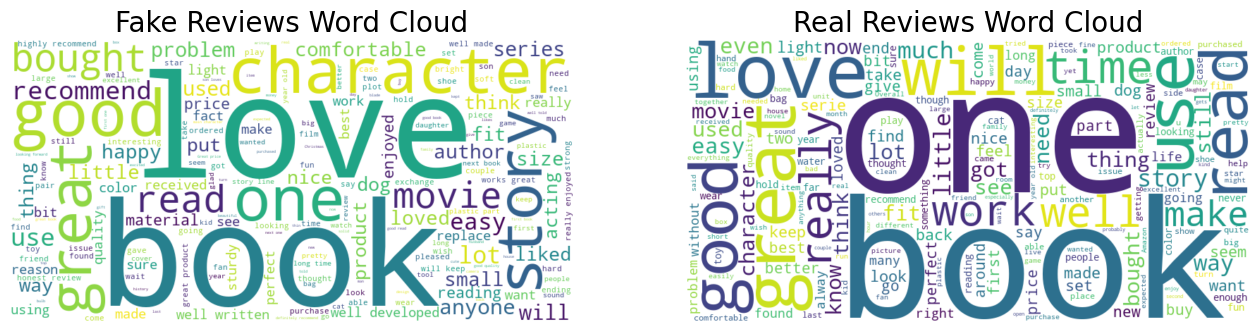

In [26]:
# Creating WordClouds for Fake and Real Reviews
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# Separate fake and real reviews
fake_reviews = ' '.join(df_filtered[df_filtered['label'] == 'CG']['text_'])
real_reviews = ' '.join(df_filtered[df_filtered['label'] == 'OR']['text_'])
# Generate word clouds
fake_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(fake_reviews)
real_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(real_reviews)
# Plot word clouds
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.imshow(fake_wordcloud, interpolation='bilinear')
plt.title('Fake Reviews Word Cloud', fontsize=20)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(real_wordcloud, interpolation='bilinear')
plt.title('Real Reviews Word Cloud', fontsize=20)
plt.axis('off')
plt.show()

## Feature Importance Analysis

Let's understand which words the model considers most important for classification. By examining the weights in the first layer of the neural network, we can identify which features (words) have the strongest influence on predictions.

### How It Works:

The first layer of the network connects each input feature (word) to 64 hidden neurons through learned weights. Words that have larger weights across these connections are more influential in making predictions. By averaging the absolute values of these weights for each word, we get a measure of overall feature importance.


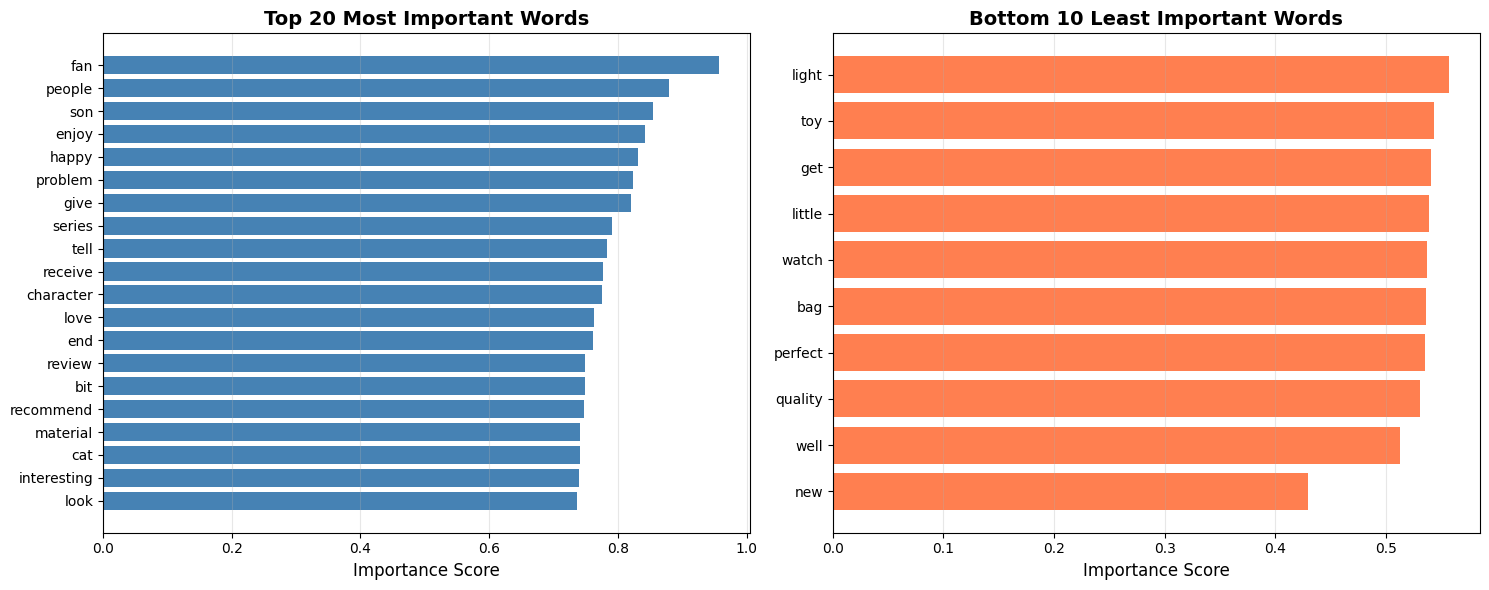

In [27]:
# Extract feature importance from the first layer weights
# The first layer connects input features (words) to hidden layer neurons

import matplotlib.pyplot as plt

# Get the weights from the first layer
first_layer_weights = model.layer1.weight.data.cpu().numpy()  # Shape: (64, 100)

# Calculate feature importance as the average absolute weight across hidden neurons
feature_importance = np.abs(first_layer_weights).mean(axis=0)

# Get feature names from the vectorizer
feature_names = vectorizer_tfidf.get_feature_names_out()

# Create a dataframe for better visualization
importance_df = pd.DataFrame({
    'word': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Top 20 most important words
top_20 = importance_df.head(20)
axes[0].barh(range(len(top_20)), top_20['importance'].values, color='steelblue')
axes[0].set_yticks(range(len(top_20)))
axes[0].set_yticklabels(top_20['word'].values)
axes[0].invert_yaxis()
axes[0].set_xlabel('Importance Score', fontsize=12)
axes[0].set_title('Top 20 Most Important Words', fontsize=14, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# Plot 2: Bottom 10 least important words
bottom_10 = importance_df.tail(10).sort_values('importance', ascending=True)
axes[1].barh(range(len(bottom_10)), bottom_10['importance'].values, color='coral')
axes[1].set_yticks(range(len(bottom_10)))
axes[1].set_yticklabels(bottom_10['word'].values)
axes[1].set_xlabel('Importance Score', fontsize=12)
axes[1].set_title('Bottom 10 Least Important Words', fontsize=14, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()


In [28]:
def predict_review(text, model, vectorizer, nlp):
    """Predict if a review is fake or real"""
    # Preprocess
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc 
              if not token.is_stop and not token.is_punct]
    processed_text = ' '.join(lemmas)
    
    # Vectorize
    X = vectorizer.transform([processed_text])
    X_tensor = torch.FloatTensor(X.toarray())
    
    # Predict
    model.eval()
    with torch.no_grad():
        output = model(X_tensor).item()
    
    prediction = "REAL" if output > 0.5 else "FAKE"
    confidence = output if output > 0.5 else (1 - output)
    
    return prediction, confidence


In [29]:

# Test examples
test_reviews = [
    "Amazing! Perfect! Best product ever! Highly recommend!",
    "I purchased this air fryer three weeks ago and have been using it regularly. The temperature control is accurate and it cooks evenly. The basket is large enough for a family meal and cleanup is straightforward.",
    "網站有中文版嗎？我想了解更多產品資訊。",
]

print("Testing new reviews:\n")
for i, review in enumerate(test_reviews, 1):
    prediction, confidence = predict_review(review, model, vectorizer_tfidf, nlp)
    print(f"Review {i}:")
    print(f"  Text: {review[:80]}...")
    print(f"  Prediction: {prediction} (confidence: {confidence:.2%})")
    print()


Testing new reviews:

Review 1:
  Text: Amazing! Perfect! Best product ever! Highly recommend!...
  Prediction: FAKE (confidence: 99.88%)

Review 2:
  Text: I purchased this air fryer three weeks ago and have been using it regularly. The...
  Prediction: FAKE (confidence: 50.84%)

Review 3:
  Text: 網站有中文版嗎？我想了解更多產品資訊。...
  Prediction: FAKE (confidence: 53.20%)



## LAB-1 Assignment

In [30]:
from sklearn.preprocessing import OneHotEncoder
# Loading dataset
df = pd.read_csv('/Users/devrajsinhgohil/Desktop/DL/fake_reviews_dataset.csv')

# One-hot encode the category column
encoder = OneHotEncoder(sparse_output=False)
encoded_categories = encoder.fit_transform(df[['category']])
category_columns = encoder.get_feature_names_out(['category'])

# Create a dataframe from the encoded categories and concatenate
encoded_df = pd.DataFrame(encoded_categories, columns=category_columns)
df = pd.concat([df, encoded_df], axis=1)

df['label'] = (df['label'] == 'CG').astype(int)

df.head()


,category,rating,label,text_,category_Books_5,category_Clothing_Shoes_and_Jewelry_5,category_Electronics_5,category_Home_and_Kitchen_5,category_Kindle_Store_5,category_Movies_and_TV_5,category_Pet_Supplies_5,category_Sports_and_Outdoors_5,category_Tools_and_Home_Improvement_5,category_Toys_and_Games_5
0,Home_and_Kitchen_5,5.0,1,"Love this! Well made, sturdy, and very comfor...",0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Home_and_Kitchen_5,5.0,1,"love it, a great upgrade from the original. I...",0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Home_and_Kitchen_5,5.0,1,This pillow saved my back. I love the look and...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Home_and_Kitchen_5,1.0,1,"Missing information on how to use it, but it i...",0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Home_and_Kitchen_5,5.0,1,Very nice set. Good quality. We have had the s...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
# tokenization
docs = nlp.pipe(df['text_'],disable=["ner","parser","textcat"],batch_size=1000, n_process=2)

In [32]:

df['lemmatized_text'] = lemmatized_texts


In [33]:
# Vectorization with TF-IDF
vectorizer = TfidfVectorizer(max_features=100)
X_tfidf = vectorizer.fit_transform(df['lemmatized_text'])



In [34]:
Y_category = df[category_columns].values

In [35]:
from sklearn.model_selection import train_test_split
# Split data into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(
    X_tfidf, Y_category, test_size=0.2, random_state=42, stratify=Y_category
)

In [36]:
# Model Definition and Training

class MultiLabelReviewDataset(Dataset):
    
    def __init__(self, features, labels):
        self.features = torch.FloatTensor(features.toarray())
        self.labels = torch.FloatTensor(labels)
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [37]:
class MultiLabelReviewClassifier(nn.Module):
    
    def __init__(self, input_size, output_size):
        super(MultiLabelReviewClassifier, self).__init__()
        
        # Define layers
        self.layer1 = nn.Linear(input_size, 128)
        self.relu1 = nn.ReLU()
        
        self.layer2 = nn.Linear(128, 128)
        self.relu2 = nn.ReLU()

        self.layer3 = nn.Linear(128, 64)
        self.relu3 = nn.ReLU()

        self.layer4 = nn.Linear(64, 64)
        self.relu4 = nn.ReLU()
        
        self.output = nn.Linear(64, output_size)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.relu1(x)
        
        x = self.layer2(x)
        x = self.relu2(x)

        x = self.layer3(x)
        x = self.relu3(x)   

        x = self.layer4(x)
        x = self.relu4(x)
        
        x = self.output(x)
        x = self.sigmoid(x)
        
        return x

In [38]:
# Training and evaluation code would follow similarly to the previous single-label example.
input_size = X_tfidf.shape[1]
output_size = Y_category.shape[1]
model = MultiLabelReviewClassifier(input_size, output_size)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [39]:
# Training

def train_multilabel_model(model, train_loader, criterion, optimizer, epochs=20):
    model.train()
    history = {'loss': [], 'accuracy': []}
    
    for epoch in range(epochs):
        epoch_loss = 0
        correct = 0
        total = 0
        
        for features, labels in train_loader:
            # Forward pass
            outputs = model(features)
            loss = criterion(outputs, labels)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Calculate accuracy
            preds = (outputs > 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.numel()
            epoch_loss += loss.item()
        
        # Calculate epoch metrics
        avg_loss = epoch_loss / len(train_loader)
        accuracy = correct / total
        
        history['loss'].append(avg_loss)
        history['accuracy'].append(accuracy)
        
        if (epoch + 1) % 5 == 0:
            print(f"Epoch [{epoch+1}/{epochs}] - Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")
    
    return history

In [40]:
# Test
def evaluate_multilabel_model(model, test_loader):
    model.eval()
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        for features, labels in test_loader:
            outputs = model(features)
            preds = (outputs > 0.5).float()
            predictions.extend(preds.tolist())
            true_labels.extend(labels.tolist())
    
    return np.array(predictions), np.array(true_labels)

In [41]:
# Data Loaders
train_dataset = MultiLabelReviewDataset(X_train, Y_train)
test_dataset = MultiLabelReviewDataset(X_test, Y_test)

In [42]:
# Training

history = train_multilabel_model(model, DataLoader(train_dataset, batch_size=32, shuffle=True), criterion, optimizer, epochs=50)

Epoch [5/50] - Loss: 0.1869, Accuracy: 0.9279
Epoch [10/50] - Loss: 0.1755, Accuracy: 0.9320
Epoch [15/50] - Loss: 0.1655, Accuracy: 0.9356
Epoch [20/50] - Loss: 0.1560, Accuracy: 0.9397
Epoch [25/50] - Loss: 0.1474, Accuracy: 0.9433
Epoch [30/50] - Loss: 0.1384, Accuracy: 0.9472
Epoch [35/50] - Loss: 0.1300, Accuracy: 0.9503
Epoch [40/50] - Loss: 0.1216, Accuracy: 0.9544
Epoch [45/50] - Loss: 0.1140, Accuracy: 0.9572
Epoch [50/50] - Loss: 0.1072, Accuracy: 0.9597


In [43]:
# Evaluation
y_pred, y_true = evaluate_multilabel_model(model, DataLoader(test_dataset, batch_size=32, shuffle=False))

In [44]:
# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"\nTest Accuracy: {accuracy:.4f}")

# Classification report
print(f"\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=category_columns))


Test Accuracy: 0.4622

Classification Report:
                                       precision    recall  f1-score   support

                     category_Books_5       0.61      0.65      0.63       874
category_Clothing_Shoes_and_Jewelry_5       0.69      0.50      0.58       770
               category_Electronics_5       0.42      0.26      0.32       798
          category_Home_and_Kitchen_5       0.43      0.21      0.29       811
              category_Kindle_Store_5       0.69      0.57      0.62       946
             category_Movies_and_TV_5       0.89      0.78      0.83       717
              category_Pet_Supplies_5       0.86      0.66      0.75       851
       category_Sports_and_Outdoors_5       0.33      0.21      0.26       789
category_Tools_and_Home_Improvement_5       0.51      0.25      0.34       772
            category_Toys_and_Games_5       0.72      0.57      0.64       759

                            micro avg       0.64      0.47      0.54      8087
   

In [45]:
# Traning with CountVectorizer
X_count = vectorizer_bow.fit_transform(df['lemmatized_text'])

In [46]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X_count, Y_category, test_size=0.2, random_state=42, stratify=Y_category
)

In [47]:
# Data Loaders
train_dataset = MultiLabelReviewDataset(X_train, Y_train)
test_dataset = MultiLabelReviewDataset(X_test, Y_test)

In [ ]:
history = train_multilabel_model(model, DataLoader(train_dataset, batch_size=32, shuffle=True), criterion, optimizer, epochs=50)
# Evaluation
y_pred, y_true = evaluate_multilabel_model(model, DataLoader(test_dataset, batch_size=32, shuffle=False))

Epoch [5/50] - Loss: 0.1152, Accuracy: 0.9578
Epoch [10/50] - Loss: 0.1051, Accuracy: 0.9613
Epoch [15/50] - Loss: 0.1000, Accuracy: 0.9633
Epoch [20/50] - Loss: 0.0935, Accuracy: 0.9658
Epoch [25/50] - Loss: 0.0896, Accuracy: 0.9676


In [ ]:
# Calculate accuracy
accuracy_cntV = accuracy_score(y_true, y_pred)
print(f"\nTest Accuracy: {accuracy_cntV:.4f}")

# Classification report
print(f"\nClassification Report:")
print(classification_report(y_true, y_pred))

# Task 1

In [ ]:
# comparing both TF-IDF and CountVectorizer results
print(f"\nTF-IDF Test Accuracy: {accuracy:.4f}")
print(f"CountVectorizer Test Accuracy: {accuracy_cntV:.4f}")